# Exercise 1 - Model Training and Evaluation

## BERT does not use TF-IDF

In [9]:
import os
import string
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, TrainingArguments, Trainer
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import re
import datetime
import json
from torch.optim import AdamW

In [5]:
# loading the dataset

# paths
train_csv = "../data/train.csv"
val_csv   = "../data/val.csv"
test_csv  = "../data/test.csv"

# load; all of them have 2 columns: Text, Label
train = pd.read_csv(train_csv)
val   = pd.read_csv(val_csv)
test  = pd.read_csv(test_csv)

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)

Train: (50587, 2) Val: (6324, 2) Test: (6324, 2)


In [6]:
import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

import unicodedata

def strip_accents_unicode(s):
    return unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')

pt_stopwords = [strip_accents_unicode(w.lower()) for w in stopwords.words('portuguese')]


In [7]:
def clean_for_bert(text, pt_stopwords):
    if pd.isna(text): return ""
    text = str(text).lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    words = text.split()
    text = " ".join([w for w in words if w not in pt_stopwords])
    return text

## b) Training models

Requirements:
- use 5-fold cross-validation
- tune key hyperparameters systematically (e.g., regularization strength λ, tree depth)
- document your hyperparameter search process

Models to use:
- Decision Tree
- Gaussian Naive Bayes
- Logistic Regression with L2 regularization
- Logistic Regression with L1 regularization
- Multi-Layer Perceptron (MLP) - You are free to choose your architecture but up to 2 hidden layers.

### BERT

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score
import numpy as np
import json
from datetime import datetime

# 1. Corrected Dataset Class
class BERTDataset(Dataset):
    def __init__(self, encodings, labels):
        # encodings is the output of the tokenizer
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # We extract the specific index for each key (input_ids, attention_mask)
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# 2. Corrected Systematic Search Function
def run_bert_systematic_search(X_raw, y_labels, param_grid, pt_stopwords, device):
    os.makedirs("../artifacts/bert/models", exist_ok=True)
    # Using Portuguese BERT as discussed
    model_name = 'neuralmind/bert-base-portuguese-cased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cleaning: No punctuation, No Portuguese stopwords
    X_clean = np.array([clean_for_bert(t, pt_stopwords) for t in X_raw])
    
    results_path = "../artifacts/bert/models/desktop/bert_cv_results.csv"
    metadata_path = "../artifacts/bert/models/desktop/bert_metadata.json"
    best_model_dir = "../artifacts/bert/models/desktop/bert_best_model"
    
    best_f1 = -1
    all_cv_results = []

    for lr in param_grid['learning_rate']:
        for wd in param_grid['weight_decay']:
            print(f"\n--- Testing Config: LR={lr}, Weight Decay(λ)={wd} ---")
            fold_scores = []
            
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_clean, y_labels)):
                # Tokenize (returns a dictionary of tensors)
                train_encodings = tokenizer(list(X_clean[train_idx]), truncation=True, padding=True, max_length=128, return_tensors='pt')
                val_encodings = tokenizer(list(X_clean[val_idx]), truncation=True, padding=True, max_length=128, return_tensors='pt')
                
                # Create the corrected datasets
                train_dataset = BERTDataset(train_encodings, y_labels[train_idx])
                # Validation also needs to be a Dataset if using a standard loop or Trainer
                val_dataset = BERTDataset(val_encodings, y_labels[val_idx])
                val_loader = DataLoader(val_dataset, batch_size=16)

                # Initialize Model
                model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
                
                # TrainingArguments (Fixed 'eval_strategy')
                training_args = TrainingArguments(
                    output_dir='./temp_bert_fold',
                    learning_rate=lr,
                    weight_decay=wd,
                    num_train_epochs=2,
                    per_device_train_batch_size=16,
                    eval_strategy="no",
                    save_strategy="no",
                    report_to="none"
                )
                
                trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset)
                trainer.train()
                
                # Validation Loop
                model.eval()
                fold_preds = []
                with torch.no_grad():
                    for batch in val_loader:
                        # Move batch to device
                        b_input_ids = batch['input_ids'].to(device)
                        b_attn_mask = batch['attention_mask'].to(device)
                        
                        logits = model(b_input_ids, attention_mask=b_attn_mask).logits
                        fold_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                
                f1 = f1_score(y_labels[val_idx], fold_preds, average='macro')
                fold_scores.append(f1)
                print(f"Fold {fold+1} F1-macro: {f1:.4f}")

            # Average score for this (LR, WD) combination
            avg_f1 = np.mean(fold_scores)
            all_cv_results.append({
                'learning_rate': lr, 'weight_decay': wd,
                'mean_f1_macro': avg_f1, 'std_f1_macro': np.std(fold_scores),
                'run_timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })

            # Save if it's the best score seen so far
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                model.save_pretrained(best_model_dir)
                tokenizer.save_pretrained(best_model_dir)
                metadata = {'best_cv_score': avg_f1, 'best_params': {'lr': lr, 'wd': wd}}
                with open(metadata_path, 'w') as f:
                    json.dump(metadata, f, indent=4)
                print(f"New Best Score: {avg_f1:.4f}. Model saved to {best_model_dir}")

    # Final CSV logging
    pd.DataFrame(all_cv_results).to_csv(results_path, index=False)
    return metadata

In [28]:
import torch
import accelerate
import transformers

print(f"Accelerate version: {accelerate.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Is GPU available: {torch.cuda.is_available()}")

Accelerate version: 1.12.0
Transformers version: 5.1.0
Is GPU available: False


In [29]:
# --- 3. Execution ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
search_space = {'learning_rate': [2e-5, 5e-5], 'weight_decay': [0.01, 0.1]}
best_meta = run_bert_systematic_search(train['Text'].values, train['Label'].astype(int).values, search_space, pt_stopwords, device)


--- Testing Config: LR=2e-05, Weight Decay(λ)=0.01 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. C

Step,Training Loss
500,0.326709
1000,0.241578
1500,0.211578
2000,0.196157
2500,0.174721
3000,0.118422
3500,0.121319
4000,0.124062
4500,0.112572
5000,0.109000


Fold 1 F1-macro: 0.9428


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. C

Step,Training Loss
500,0.323419
1000,0.240335
1500,0.207852
2000,0.185355
2500,0.179513
3000,0.120149
3500,0.107972
4000,0.119325
4500,0.107300
5000,0.102224


Fold 2 F1-macro: 0.9441


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. C

Step,Training Loss
500,0.327426
1000,0.234842
1500,0.212811
2000,0.187817
2500,0.182374
3000,0.123276
3500,0.124986
4000,0.120047
4500,0.108514
5000,0.103660


Fold 3 F1-macro: 0.9441


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. C

Step,Training Loss
500,0.325424
1000,0.233572
1500,0.192213
2000,0.189457
2500,0.181444
3000,0.125176
3500,0.116415
4000,0.106628
4500,0.114034
5000,0.110002


Fold 4 F1-macro: 0.9432


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. C

Step,Training Loss
500,0.316724
1000,0.233247
1500,0.205514
2000,0.179050
2500,0.173032
3000,0.116007
3500,0.123529
4000,0.112598
4500,0.112468
5000,0.100115


Fold 5 F1-macro: 0.9415


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

New Best Score: 0.9431. Model saved to ../artifacts/bert/models/bert_best_model

--- Testing Config: LR=2e-05, Weight Decay(λ)=0.1 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. C

Step,Training Loss
500,0.334221
1000,0.242814
1500,0.214011
2000,0.194814
2500,0.166673
3000,0.121488
3500,0.128314
4000,0.128101
4500,0.111685
5000,0.110260


KeyboardInterrupt: 

### Evaluation

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, f1_score, accuracy_score, 
                             precision_score, recall_score, roc_curve, auc)
from transformers import BertTokenizer, BertForSequenceClassification

In [2]:
def load_bert_model(type):
    # Points to the directory saved by model.save_pretrained()
    best_model_dir = f"../artifacts/bert/models/{type}/bert_best_model"
    tokenizer = BertTokenizer.from_pretrained(best_model_dir)
    model = BertForSequenceClassification.from_pretrained(best_model_dir)
    return model, tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_bert_desktop, bert_tokenizer_desktop = load_bert_model("desktop")
best_bert_desktop.to(device)
best_bert_desktop.eval()

best_bert_kaggle_dudu, bert_tokenizer_kaggle_dudu = load_bert_model("kaggle-dudu")
best_bert_kaggle_dudu.to(device)
best_bert_kaggle_dudu.eval()

best_bert_kaggle_dani, bert_tokenizer_kaggle_dani = load_bert_model("kaggle-dani")
best_bert_kaggle_dani.to(device)
best_bert_kaggle_dani.eval()

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [3]:
def get_bert_predictions(model, tokenizer, texts, device, batch_size=16):
    all_preds = []
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = list(texts[i:i+batch_size])
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                           max_length=128, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy()) # Probability of Positive Class
            
    return np.array(all_preds), np.array(all_probs)

# 3. Validation and Test Helpers
def evaluate_bert_model(model, tokenizer, texts, y_true, name):
    y_pred, _ = get_bert_predictions(model, tokenizer, texts, device)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n{name} – Validation F1-macro: {f1:.4f}")
    print(classification_report(y_true, y_pred))
    return f1

def evaluate_bert_test(model, tokenizer, texts, y_true):
    y_pred, _ = get_bert_predictions(model, tokenizer, texts, device)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro"),
        "recall_macro": recall_score(y_true, y_pred, average="macro"),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }

## c) Comparison table

### Based on test metrics

In [16]:
val['text_bert'] = val['Text'].apply(lambda x: clean_for_bert(x, pt_stopwords))
test['text_bert'] = test['Text'].apply(lambda x: clean_for_bert(x, pt_stopwords))
val_texts = val['text_bert'].values
test_texts = test['text_bert'].values
y_val_labels = val['Label'].astype(int).values
y_test_labels = test['Label'].astype(int).values

val_results = {
    "BERT-PC": evaluate_bert_model(best_bert_desktop, bert_tokenizer_desktop, val_texts, y_val_labels, "BERT"),
    "BERT-DUDU": evaluate_bert_model(best_bert_kaggle_dudu, bert_tokenizer_kaggle_dudu, val_texts, y_val_labels, "BERT"),
    "BERT-DANI": evaluate_bert_model(best_bert_kaggle_dani, bert_tokenizer_kaggle_dani, val_texts, y_val_labels, "BERT")
}


BERT – Validation F1-macro: 0.9440
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3141
           1       0.94      0.94      0.94      3183

    accuracy                           0.94      6324
   macro avg       0.94      0.94      0.94      6324
weighted avg       0.94      0.94      0.94      6324


BERT – Validation F1-macro: 0.9456
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3141
           1       0.95      0.95      0.95      3183

    accuracy                           0.95      6324
   macro avg       0.95      0.95      0.95      6324
weighted avg       0.95      0.95      0.95      6324


BERT – Validation F1-macro: 0.9470
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3141
           1       0.95      0.95      0.95      3183

    accuracy                           0.95      6324
   macro avg       0

In [13]:
test_results = {
    "BERT-PC": evaluate_bert_test(best_bert_desktop, bert_tokenizer_desktop, test_texts, y_test_labels),
    "BERT-DUDU": evaluate_bert_test(best_bert_kaggle_dudu, bert_tokenizer_kaggle_dudu, test_texts, y_test_labels),
    "BERT-DANI": evaluate_bert_test(best_bert_kaggle_dani, bert_tokenizer_kaggle_dani, test_texts, y_test_labels)
}

# 5. Build Comparison Table
df_test = pd.DataFrame(test_results).T
print("\n=== Test Set Comparison Table ===")
display(df_test)

# Save results
output_path = "../artifacts/bert/models/test_results.csv"
df_test.to_csv(output_path)


=== Test Set Comparison Table ===


,accuracy,precision_macro,recall_macro,f1_macro
BERT-PC,0.947660,0.947738,0.947675,0.947658
BERT-DUDU,0.946078,0.946087,0.946074,0.946078
BERT-DANI,0.945446,0.945450,0.945450,0.945446


In [14]:
# select best model (based on F1-macro)
best_bert_name = df_test["f1_macro"].idxmax()
print("\nBest model based on Test F1-macro:", best_bert_name)

# retrieve actual model
best_bert = {
    "BERT-PC": best_bert_desktop,
    "BERT-DUDU": best_bert_kaggle_dudu,
    "BERT-DANI": best_bert_kaggle_dani,
}[best_bert_name]

# retrieve actual tokenizer
best_bert_tokenizer = {
    "BERT-PC": bert_tokenizer_desktop,
    "BERT-DUDU": bert_tokenizer_kaggle_dudu,
    "BERT-DANI": bert_tokenizer_kaggle_dani,
}[best_bert_name]


Best model based on Test F1-macro: BERT-PC


### ROC Curve + Macro-Averaged AUC

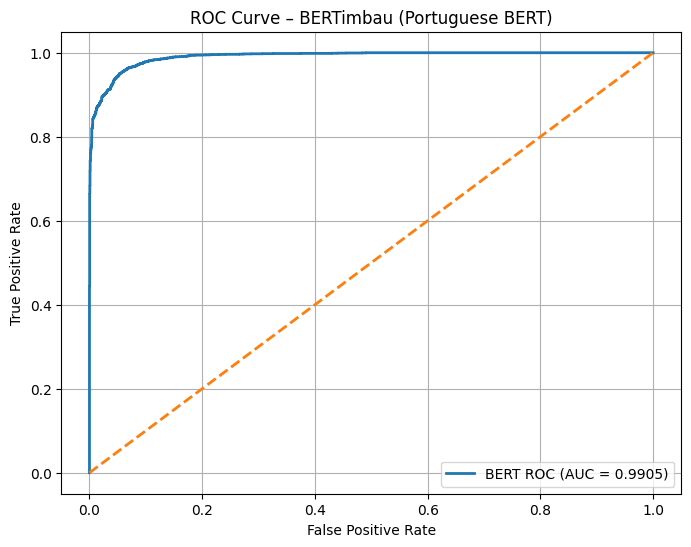


Final AUC: 0.9905


In [15]:
y_pred_test, y_score_test = get_bert_predictions(best_bert, best_bert_tokenizer, test_texts, device)
fpr, tpr, _ = roc_curve(y_test_labels, y_score_test, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"BERT ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – BERTimbau (Portuguese BERT)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nFinal AUC: {roc_auc:.4f}")